In [1]:
%run 1_Function_Master.ipynb 
%run 2_Parameterization.ipynb

## Defining Parameterization and Initial Conditions

In [2]:
print_parameterization(param)

╒════════════════════════════════════════╤═══════════════╤═════════════════╤═══════════════╤══════════════════════╕
│ V_max = 1.4                            │ λ_P = 0.05    │ μ_V = 0.5       │ μ_P = 0.4     │ K_I = 1.0            │
├────────────────────────────────────────┼───────────────┼─────────────────┼───────────────┼──────────────────────┤
│ γ_Z = 0.4                              │ λ_Z = 0.05    │ μ_V_prime = 1.0 │ μ_delta = 0.4 │ K_h = 1.0            │
├────────────────────────────────────────┼───────────────┼─────────────────┼───────────────┼──────────────────────┤
│ φ = 110236.2205                        │ λ_Z_hat = 0.1 │ μ_u = 0.0       │ μ_g = 0.4     │ K_P = 2.8            │
├────────────────────────────────────────┼───────────────┼─────────────────┼───────────────┼──────────────────────┤
│ g = 1.4                                │ λ_E = 0.5     │ μ_r = 0.5       │ μ_Z = 0.4     │ I_0 = e - 1 = 1.7183 │
├────────────────────────────────────────┼───────────────┼──────────────

In [3]:
''' Read stored files from Multi_Simulation_Animations.ipynb. '''

%store -r sols

In [5]:
''' Sort solution set into steady or oscillatory solutions. '''

ss_sols = []
osc_sols = []

for z0, sol in sols: 
    info = ss_or_osc(sol)
    
    if info == 'osc':
        osc_sols.append([z0, sol])
        
    else:
        ss_sols.append([z0, sol] + list(info))
        
print(f'Out of {len(sols)} solutions, {len(ss_sols)} are steady (or decay) and {len(osc_sols)} are oscillatory.')

Out of 200 solutions, 176 are steady (or decay) and 24 are oscillatory.


## Quick Visualization of Solutions

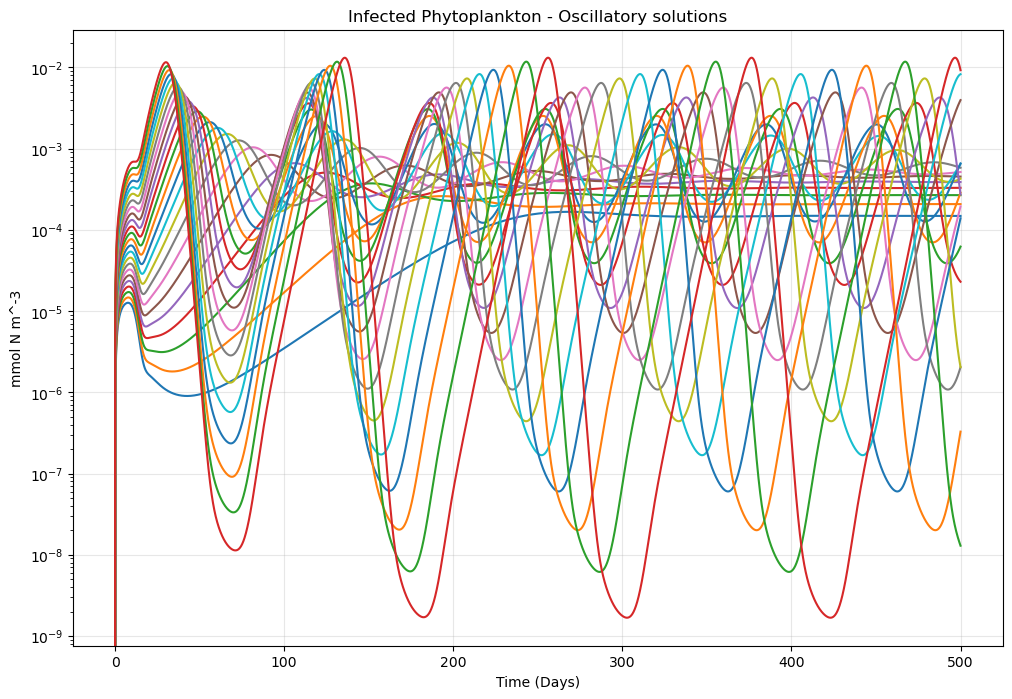

In [6]:
plt.figure(figsize=(12, 8))

for z0, sol in osc_sols: 
    plt.plot(sol.t, sol.y[3])

    
plt.title('Infected Phytoplankton - Oscillatory solutions')
plt.xlabel('Time (Days)')
plt.ylabel('mmol N m^-3')

plt.grid(alpha=.3)

plt.yscale('log')
# plt.ylim(1e-12, 1)

plt.show()

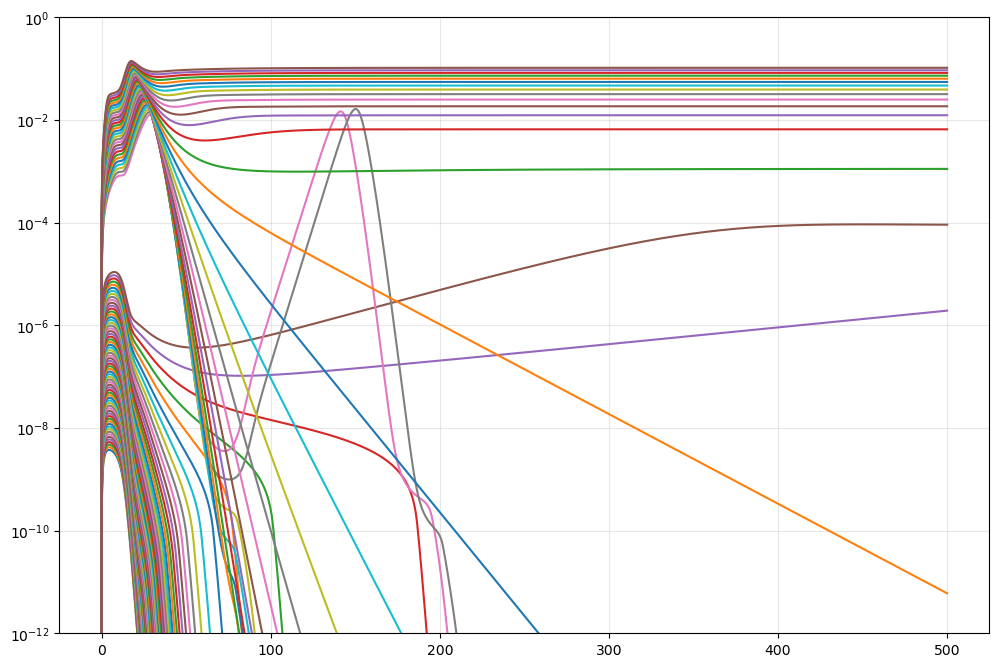

In [7]:
plt.figure(figsize=(12, 8))

for z0, sol, ss, conv_ind in ss_sols: 
    if sum(z0) < .2:
        plt.plot(sol.t, sol.y[3])

plt.grid(alpha=.3)
plt.yscale('log')
plt.ylim(1e-12, 1)
plt.show()

## Creating Data Frame

In [8]:
''' 
Create data set from steady state solutions tracking the final values of 
each state, the free virus to phytoplankton ratio, and burst size
'''

data = []

for z0, sol, ss, conv_index in ss_sols:
    
    # Pulling steady state values for each state variable
    ss_Nn, ss_Nr, ss_Pu, ss_Pi, ss_Z, ss_Vi, ss_Ve = ss
    
    # Calculating ratio of individual extracellular viruses to collective phytoplankton
    r = est_viral_ratio(ss_Ve, (ss_Pu + ss_Pi), alpha, beta, S_ind, V_ind)
    
    # Number of individual intracellular viruses per infected host
    burst_size = 1 / est_viral_ratio(ss_Vi, ss_Pi, alpha, beta, S_ind, V_ind)

    data.append([sum(z0), ss_Nr, ss_Pu, ss_Pi, ss_Z, ss_Vi, ss_Ve, 1/r, burst_size])
    
df = pd.DataFrame(data, columns = ['Total N', 'SS N_r', 'SS P_U', 'SS P_I', 'SS Z', 'SS V_I', 'SS V_E', 'Free V_E : Phyto', 'Burst Size'])

In [28]:
''' 
Here we filter out solutions where the sum of pyhtoplankton are 
below a reasonable concetration, since it skews the ratios and results.
E.g. when calculating Ve:P ratio, if P is tiny (< 1e-12) the ratio is largely
inflated. Not necessarily inaccurate, but skews the view of the data.
'''

filtered_df = df[(df['SS P_I'] + df['SS P_U']) > 1e-12]
filtered_df.describe()

,Total N,SS N_r,SS P_U,SS P_I,SS Z,SS V_I,SS V_E,Free V_E : Phyto,Burst Size
count,140.000000,140.000000,1.400000e+02,1.400000e+02,1.400000e+02,1.400000e+02,1.400000e+02,1.400000e+02,1.400000e+02
mean,2.534122,1.344285,2.231422e-03,4.903290e-01,6.966424e-01,4.392235e-04,1.944679e-04,1.309816e+02,2.722038e+102
std,4.457428,3.236448,8.808224e-03,5.683240e-01,9.672583e-01,4.113625e-04,2.300466e-04,1.711690e+02,1.823343e+103
min,0.001011,0.001011,-2.304811e-55,4.214927e-215,2.806963e-15,4.736097e-116,1.083779e-113,1.220487e-101,4.081710e+01
25%,0.007547,0.003704,0.000000e+00,1.412598e-179,3.063313e-14,1.126975e-103,2.223380e-101,7.942586e-95,1.373181e+02
50%,0.358906,0.091716,0.000000e+00,2.519216e-01,1.366520e-02,3.809595e-04,6.359467e-05,1.017821e+01,6.231568e+02
75%,2.679489,0.280086,3.049842e-10,9.655861e-01,1.432775e+00,8.654275e-04,3.852859e-04,2.946112e+02,5.295830e+82
max,20.000000,16.019897,4.794867e-02,1.492981e+00,2.486700e+00,1.085210e-03,6.317211e-04,5.275624e+02,1.858002e+104


## Visualizing Free Virus : Host Ratio and Burst Size

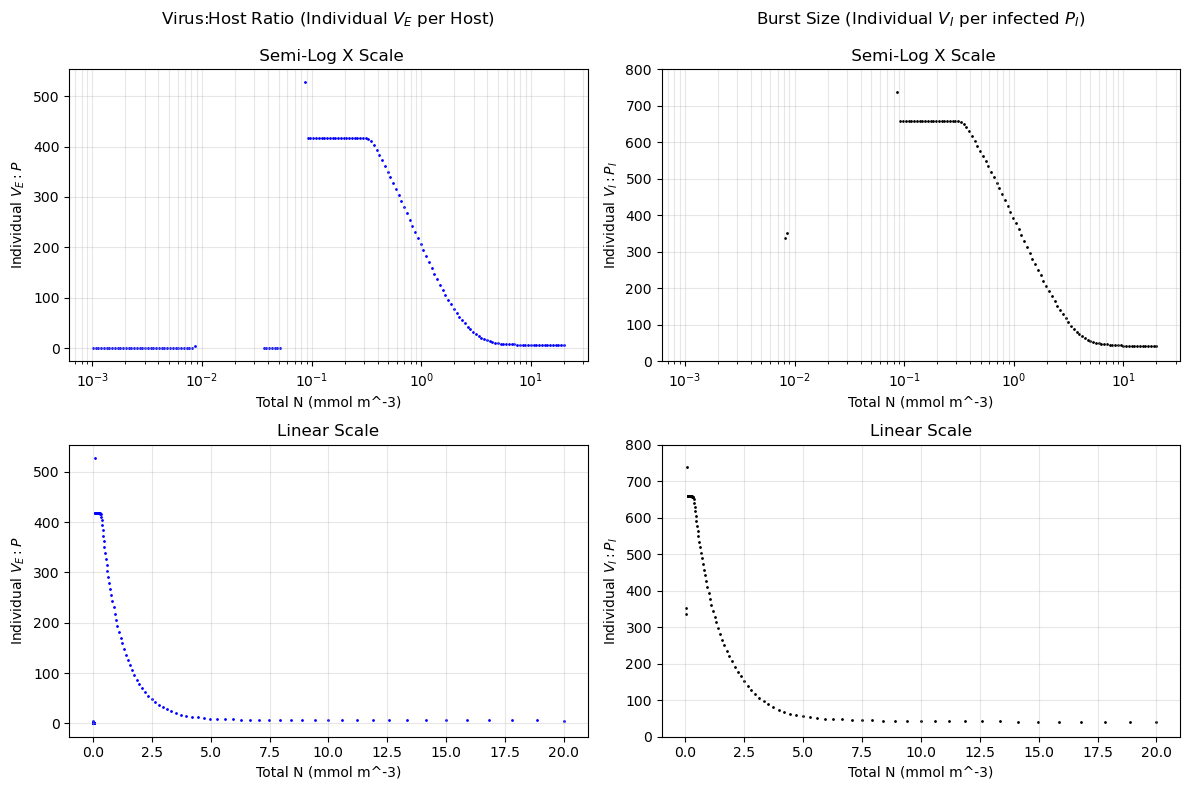

In [24]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))


axs[0][0].scatter(filtered_df['Total N'], filtered_df['Free V_E : Phyto'], color='blue', s=1)
axs[0][0].set_title(r'Virus:Host Ratio (Individual $V_E$ per Host)'
                    '\n\n Semi-Log X Scale')

axs[0][0].set_ylabel(r'Individual $V_E : P$')
axs[0][0].set_xscale('log')

axs[1][0].scatter(filtered_df['Total N'], filtered_df['Free V_E : Phyto'], color='blue', s=1)
axs[1][0].set_title('Linear Scale')
axs[1][0].set_ylabel(r'Individual $V_E : P$')

axs[0][1].scatter(filtered_df['Total N'], filtered_df['Burst Size'], color='black', s=1)
axs[0][1].set_title(r'Burst Size (Individual $V_I$ per infected $P_I$)'
                    '\n\n Semi-Log X Scale')
axs[0][1].set_ylabel(r'Individual $V_I : P_I$')
axs[0][1].set_xscale('log')
axs[0][1].set_ylim(0, 800)

axs[1][1].scatter(filtered_df['Total N'], filtered_df['Burst Size'], color='black', s=1)
axs[1][1].set_title('Linear Scale')
axs[1][1].set_ylabel(r'Individual $V_I : P_I$')
axs[1][1].set_ylim(0, 800)

for ax in axs.reshape(-1):
    ax.set_xlabel('Total N (mmol m^-3)')
    ax.grid(which='both', alpha=.3)
    
plt.tight_layout()
plt.show()

In [33]:
'''Pulling Examples of  '''

# print(filtered_df.iloc[611, [0, 7, 8]], end='\n\n')
simulation_num = 135
columns = [0, 7, 8]

print(filtered_df.iloc[simulation_num, columns], end='\n\n')

Total N             15.868193
Free V_E : Phyto     5.937390
Burst Size          41.294541
Name: 171, dtype: float64



## Spearman's Correlation Coeff (Rho)

The Spearman's Correlation Coefficient can be used to assess the correlation between two non-parametric data sets. Since both data sets are not normally distributed and have an obviously non-linear relationship, this is the best method to determine their correlation. 

The Spearman Coefficient assumes a monotonic relationship between data (check).

-1 (1) corresponds to a perfectly negative (postive) correlation. 

In [38]:
from scipy.stats import spearmanr

# Calculate the Spearman's Correlation Coefficient between Total N and Ve:P ratio
corr, _ = spearmanr(filtered_df['Total N'], filtered_df['Free V_E : Phyto'])
print('Spearmans correlation: %.3f' % corr)

Spearmans correlation: 0.354


In [39]:
# Calculate Spearman's Correlation Coefficient between Total N and Burst Size
corr, _ = spearmanr(filtered_df['Total N'], filtered_df['Burst Size'])
print('Spearmans correlation: %.3f' % corr)

Spearmans correlation: -0.986
